In [1]:
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv", index_col = "id", engine = "pyarrow")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv", index_col = "id", engine="pyarrow")

In [3]:
train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [4]:
#train_data.drop("id", axis = 1, inplace = True)
#test_data.drop("id", axis = 1, inplace = True)

In [5]:
train_data.info();print('\n');test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


<class 'pandas.core.frame.DataFrame'>
Index: 7669866 entries, 11504798 to 19174663
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehic

In [6]:
def preprocess_data(train, test):
    # Concatenate train and test dataframes
    df = pd.concat([train, test], ignore_index=True)
    
    # Replace and cast values in the dataframe
    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1}).astype(np.uint8)
    df['Region_Code'] = df['Region_Code'].astype('int8')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    
    df['Vehicle_Age'] = df['Vehicle_Age'].replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).astype('int8')
    df['Vehicle_Damage'] = df['Vehicle_Damage'].replace({'No': 0, 'Yes': 1}).astype(np.uint8)
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
    df['Vintage'] = df['Vintage'].astype('int16')
    df['Response'] = df['Response'].astype('Int8') #Int to handle Nan
    
    # Create new columns with factorized values
    df['Previously_Insured_Annual_Premium'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str))[0].astype('int32')
    df['Previously_Insured_Vehicle_Age'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vehicle_Age'].astype(str))[0].astype('int8')
    df['Previously_Insured_Vehicle_Damage'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vehicle_Damage'].astype(str))[0].astype('int8')
    df['Previously_Insured_Vintage'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vintage'].astype(str))[0].astype('int16')
    
    return df

In [7]:
df = preprocess_data(train_data, test_data)
train_data = df[:train_data.shape[0]]
test_data = df[train_data.shape[0]:].drop(columns = 'Response')
print('Preprocess done!')

Preprocess done!


In [8]:
X = train_data.drop("Response", axis = 1)
y = train_data["Response"]

In [9]:
Stratkfold = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 7)

In [10]:
%%time
def kfold_vals(X, y, Stratkfold, test):
    folds = Stratkfold
    test_preds = np.zeros(len(test))
    y_preds = np.zeros(len(y))
    y_vals = np.zeros(len(y))
    
    scores = []
    
    for n_fold, (train_index, test_index) in enumerate(folds.split(X, y)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_val, y_val = X.iloc[test_index], y.iloc[test_index]
        
        model = CatBoostClassifier(task_type = "GPU")
        model.fit(X_train, y_train,
                 eval_set = [(X_val, y_val)],
                 cat_features = X.columns.values)
        y_pred_val = model.predict_proba(X_val)[:, 1]
        y_preds[test_index] = y_pred_val
        y_vals[test_index] = y_val
        score = roc_auc_score(y_val, y_pred_val)
        scores.append(score)
        
        test_preds += model.predict_proba(test)[:, 1] / folds.get_n_splits()
        print(f"Fold {n_fold + 1} ROC-AUC score : {score:.5f}")
        print("\n")
        print(f"Train ROC-AUC Score: {scores}")
        print(f'Mean ROC-AUC score +/- std. dev.: '
        f'{np.array(scores).mean():.5f} +/- {np.array(scores).std():.3f}')
        
        return y_preds, y_vals, test_preds

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [11]:
%%time
y_pred, y_vals, test_preds = kfold_vals(X, y, Stratkfold, test_data)

Learning rate set to 0.034114
0:	learn: 0.6405806	test: 0.6405517	best: 0.6405517 (0)	total: 1.34s	remaining: 22m 20s
1:	learn: 0.5944193	test: 0.5943757	best: 0.5943757 (1)	total: 2.49s	remaining: 20m 42s
2:	learn: 0.5525357	test: 0.5524759	best: 0.5524759 (2)	total: 3.41s	remaining: 18m 53s
3:	learn: 0.5202468	test: 0.5201377	best: 0.5201377 (3)	total: 4.32s	remaining: 17m 54s
4:	learn: 0.4832440	test: 0.4830231	best: 0.4830231 (4)	total: 5.13s	remaining: 17m
5:	learn: 0.4559038	test: 0.4557040	best: 0.4557040 (5)	total: 5.91s	remaining: 16m 18s
6:	learn: 0.4295929	test: 0.4293850	best: 0.4293850 (6)	total: 6.94s	remaining: 16m 24s
7:	learn: 0.4074087	test: 0.4071983	best: 0.4071983 (7)	total: 7.84s	remaining: 16m 12s
8:	learn: 0.3893851	test: 0.3891589	best: 0.3891589 (8)	total: 8.74s	remaining: 16m 2s
9:	learn: 0.3738569	test: 0.3735565	best: 0.3735565 (9)	total: 9.48s	remaining: 15m 38s
10:	learn: 0.3600851	test: 0.3596923	best: 0.3596923 (10)	total: 10.2s	remaining: 15m 21s
11:	l

In [12]:
def roc_auc_graph(y_true, y_pred):
    x, y, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(x, y)
    plt.figure(figsize = (10, 8))
    plt.plot(x, y, color = "darkorange", lw = 2, label = "ROC Curve (area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Graph")
    plt.legend(loc = "lower right")
    plt.show()
    print(f"ROC_AUC Score: {roc_auc_score(y_true, y_pred):.5f}")
    print(f"{roc_auc_score(y_true, y_pred):.5f}")

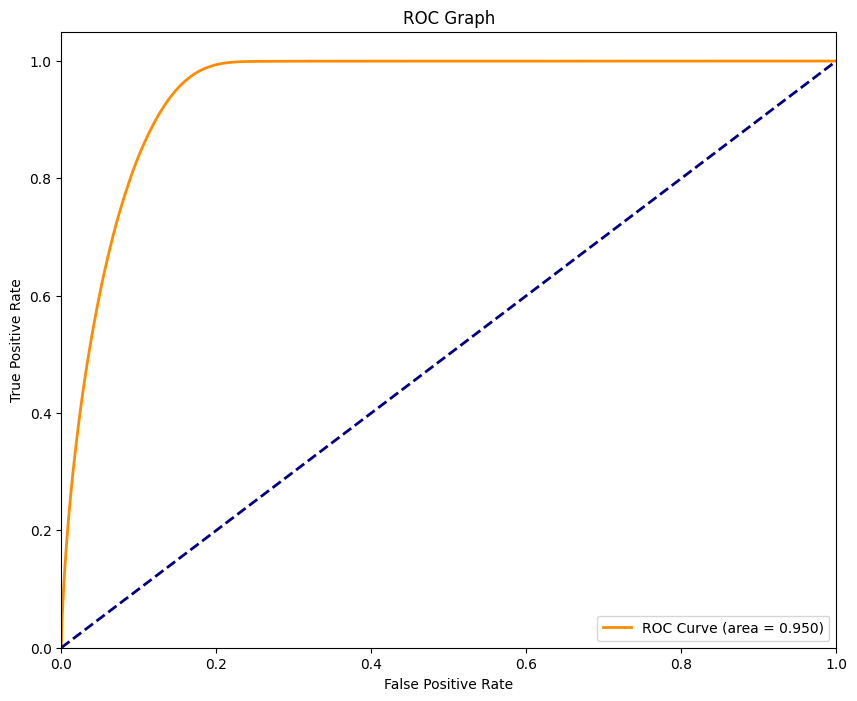

ROC_AUC Score: 0.94975
0.94975


In [13]:
roc_auc_graph(y_vals, y_pred)